In [1]:
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm
import requests
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
from pandas.core.common import flatten

%matplotlib inline

## Prepare Data
Add the Zillow Housing Values Data and filter it to focus on Colorado (Outside of Denver Metro Area). 

In [2]:
df = pd.read_csv('csv/zillowfcast.csv', header=0)
df.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,190398.0,189850.0,...,634054.0,634278.0,633853.0,634318.0,634515.0,636021.0,637194.0,639617.0,642143.0,645143.0
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,184549.0,184526.0,...,728217.0,734778.0,741304.0,747043.0,749468.0,751337.0,758225.0,767969.0,779202.0,788122.0
2,39051,2,Houston,City,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,93996.0,94111.0,...,191067.0,191548.0,192467.0,193609.0,194580.0,195274.0,196053.0,196951.0,198489.0,199976.0
3,17426,3,Chicago,City,IL,IL,Chicago-Naperville-Elgin,Cook County,139984.0,139826.0,...,264568.0,265130.0,266031.0,266788.0,267648.0,268834.0,270837.0,273295.0,276572.0,279986.0
4,6915,4,San Antonio,City,TX,TX,San Antonio-New Braunfels,Bexar County,97472.0,97437.0,...,193078.0,193243.0,193916.0,194255.0,194823.0,195380.0,196299.0,197446.0,198886.0,200621.0
5,13271,5,Philadelphia,City,PA,PA,Philadelphia-Camden-Wilmington,Philadelphia County,71557.0,71465.0,...,187752.0,188564.0,189738.0,191377.0,192682.0,194257.0,196097.0,198763.0,201278.0,204082.0
6,40326,6,Phoenix,City,AZ,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,96887.0,97180.0,...,260629.0,262663.0,265012.0,268310.0,271333.0,274251.0,277160.0,280802.0,285116.0,289769.0
7,18959,7,Las Vegas,City,NV,NV,Las Vegas-Henderson-Paradise,Clark County,147000.0,146880.0,...,282618.0,283364.0,285328.0,286988.0,288019.0,288415.0,289716.0,292388.0,296085.0,299020.0
8,54296,8,San Diego,City,CA,CA,San Diego-Carlsbad,San Diego County,187934.0,187552.0,...,644706.0,648568.0,653221.0,656557.0,660877.0,663602.0,667352.0,673456.0,682932.0,693605.0
9,38128,9,Dallas,City,TX,TX,Dallas-Fort Worth-Arlington,Dallas County,100144.0,100140.0,...,222779.0,222643.0,222969.0,224077.0,225513.0,227117.0,228985.0,230732.0,232919.0,236652.0


In [3]:
# create boolean filtered on Colorado to narrow the data frame

is_co = df['StateName']=='CO'
print(is_co.head())


0    False
1    False
2    False
3    False
4    False
Name: StateName, dtype: bool


In [4]:
# new colorado only dataframe 
df_co = pd.DataFrame(df[is_co])
df_co.shape


(400, 306)

In [5]:
df_co.sort_values('SizeRank').head(30)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
23,11093,23,Denver,City,CO,CO,Denver-Aurora-Lakewood,Denver County,125574.0,126145.0,...,454200.0,456074.0,458325.0,460165.0,461774.0,463274.0,465260.0,467711.0,470504.0,474501.0
42,4172,42,Colorado Springs,City,CO,CO,Colorado Springs,El Paso County,128992.0,129442.0,...,314635.0,317411.0,320713.0,324166.0,327350.0,330232.0,333083.0,336165.0,339378.0,343302.0
56,16846,57,Aurora,City,CO,CO,Denver-Aurora-Lakewood,Arapahoe County,123891.0,124358.0,...,363087.0,364453.0,365742.0,367043.0,369041.0,371448.0,374028.0,377475.0,380928.0,385251.0
153,4764,154,Fort Collins,City,CO,CO,Fort Collins,Larimer County,160096.0,160093.0,...,422045.0,422473.0,423687.0,426097.0,428855.0,431404.0,433079.0,435263.0,437439.0,440690.0
199,47250,201,Pueblo,City,CO,CO,Pueblo,Pueblo County,80026.0,80435.0,...,190422.0,192035.0,193725.0,195520.0,197321.0,199394.0,201650.0,204318.0,206969.0,209803.0
205,5519,208,Lakewood,City,CO,CO,Denver-Aurora-Lakewood,Jefferson County,132566.0,133191.0,...,438307.0,440347.0,442452.0,444286.0,447057.0,449060.0,452004.0,455768.0,460705.0,465656.0
254,20793,258,Thornton,City,CO,CO,Denver-Aurora-Lakewood,Adams County,137470.0,138040.0,...,396721.0,397895.0,400006.0,401920.0,404773.0,406650.0,409086.0,412074.0,416178.0,420490.0
260,30543,264,Boulder,City,CO,CO,Boulder,Boulder County,221773.0,221870.0,...,761797.0,761385.0,761653.0,761680.0,762282.0,762937.0,765162.0,768804.0,773771.0,781082.0
300,34781,305,Westminster,City,CO,CO,Denver-Aurora-Lakewood,Adams County,132660.0,133152.0,...,403715.0,405107.0,406937.0,408716.0,411588.0,413658.0,416468.0,419855.0,424230.0,428705.0
308,10181,313,Arvada,City,CO,CO,Denver-Aurora-Lakewood,Jefferson County,145992.0,146531.0,...,452382.0,454414.0,456618.0,458652.0,461956.0,464516.0,468226.0,472654.0,478156.0,483642.0


In [6]:
#Drop larger metro areas since focus is on small/med towns

df_co = df_co[~df_co['Metro'].isin(['Denver-Aurora-Lakewood', 'Boulder', 'Fort Collins', 'Colorado Springs', 'Pueblo', 'Greeley'])]
              
              

In [7]:
df_co.shape

(233, 306)

In [9]:
# Twin Lakes CO does not geocode correctly, so dropping from df
df_co = df_co[df_co['RegionName'] != 'Twin Lakes']
df_co.shape

(232, 306)

Now let's add in a concatenated address column to support more accurate geocoding results, given we do not have street addresses to leverage.

In [10]:
# add column with county and full statename for better geocoding
df_co['State'] = df_co['State'].replace(['CO'],'Colorado')
df_co['citystate'] = df_co['RegionName'].astype(str) + ', ' + \
        df_co['CountyName'].astype(str) + ', ' + \
        df_co['State'] 

df_co.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate
375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,107972.0,...,261728.0,263850.0,265254.0,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado"
1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,NaN,...,458854.0,455431.0,452199.0,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado"
1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,107189.0,...,293171.0,293896.0,294655.0,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado"
2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,NaN,...,239378.0,240159.0,240605.0,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado"
3149,20642,3260,Steamboat Springs,City,CO,Colorado,Steamboat Springs,Routt County,196113.0,196699.0,...,665992.0,665643.0,663852.0,660203.0,659121.0,660488.0,665465.0,670768.0,679042.0,"Steamboat Springs, Routt County, Colorado"


Now we will set up GeoPy's Nominatim package to generate lat, long for each city in our data frame.  First we will test on Grand Junction and the state of Colorado 

In [11]:
# create user_agent to identify lat/long coordinates per city
address = "Grand Junction, Mesa County, Colorado"

geolocator = Nominatim(timeout=5, user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

39.063956 -108.5507317


In [12]:
# Retrieving colorado lat/long for use in Folium Maps 
co_address = "Colorado, United States"

location2 = geolocator.geocode(co_address)
latitude2 = location2.latitude
longitude2 = location2.longitude
print(latitude2, longitude2)

38.7251776 -105.6077167


In [13]:
# geocoding each city in the dataframe
df_co['gcode'] = df_co.citystate.apply(geolocator.geocode)

In [14]:
#extracting the lat and long into separate columns
df_co['Lat'] = df_co['gcode'].apply(lambda x: x.latitude if x else None)
df_co['Lon'] = df_co['gcode'].apply(lambda x: x.longitude if x else None)
 
df_co.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
24975,47188,29449,Poncha Springs,City,CO,Colorado,NaN,Chaffee County,NaN,NaN,...,309436.0,309983.0,310457.0,311004.0,311275.0,311745.0,"Poncha Springs, Chaffee County, Colorado","(Poncha Springs, Chaffee County, Colorado, 812...",38.513969,-106.075332
25241,56562,29449,Williamsburg,City,CO,Colorado,Cañon City,Fremont County,NaN,NaN,...,182013.0,181907.0,182478.0,182297.0,182618.0,182326.0,"Williamsburg, Fremont County, Colorado","(Williamsburg, Fremont County, Colorado, Unite...",38.381944,-105.151933
25626,5100,29449,Haxtun,City,CO,Colorado,NaN,Phillips County,NaN,NaN,...,113964.0,113991.0,114590.0,115265.0,115870.0,116516.0,"Haxtun, Phillips County, Colorado","(Haxtun, Phillips County, Colorado, 80731, Uni...",40.641102,-102.626858
25801,20169,29449,Rico,City,CO,Colorado,NaN,Dolores County,NaN,NaN,...,282955.0,281988.0,280692.0,280922.0,280722.0,280886.0,"Rico, Dolores County, Colorado","(Rico, Dolores County, Colorado, United States...",37.692686,-108.031502
25853,22690,29449,Woody Creek,City,CO,Colorado,Glenwood Springs,Pitkin County,NaN,NaN,...,487123.0,488786.0,489187.0,487962.0,486693.0,485434.0,"Woody Creek, Pitkin County, Colorado","(Woody Creek, Pitkin County, Colorado, 81656, ...",39.270263,-106.886152


In [15]:
df_co.reset_index(inplace=True)
df_co.head()

,index,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
0,375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,...,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado","(Grand Junction, Mesa County, Colorado, United...",39.063956,-108.550732
1,1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,...,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado","(Durango, La Plata County, Colorado, United St...",37.271395,-107.881598
2,1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,...,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado","(Montrose, Montrose County, Colorado, 81401, U...",38.478193,-107.876277
3,2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,...,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado","(Cañon City, Fremont County, Colorado, 81212, ...",38.442364,-105.222495
4,3149,20642,3260,Steamboat Springs,City,CO,Colorado,Steamboat Springs,Routt County,196113.0,...,660203.0,659121.0,660488.0,665465.0,670768.0,679042.0,"Steamboat Springs, Routt County, Colorado","(Steamboat Springs, Routt County, Colorado, Un...",40.484800,-106.831736


In [16]:
#creating new dataframe to reduce the datasize
#new = old[['A', 'C', 'D']].copy()
df = df_co[['SizeRank', 'citystate', 'Lat', 'Lon', '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30', '2017-03-31', '2017-09-30', '2018-03-31','2018-09-30', '2019-03-31', '2019-09-30', 
           '2020-03-31', '2020-09-30']].copy()
df

,SizeRank,citystate,Lat,Lon,2015-03-31,2015-09-30,2016-03-31,2016-09-30,2017-03-31,2017-09-30,2018-03-31,2018-09-30,2019-03-31,2019-09-30,2020-03-31,2020-09-30
0,380,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,187464.0,193459.0,200019.0,206262.0,211034.0,218233.0,228003.0,238510.0,244346.0,253659.0,263850.0,272388.0
1,1699,"Durango, La Plata County, Colorado",37.271395,-107.881598,401933.0,406547.0,416453.0,425253.0,431981.0,440280.0,451297.0,447563.0,463971.0,470281.0,455431.0,464640.0
2,1716,"Montrose, Montrose County, Colorado",38.478193,-107.876277,229988.0,240223.0,247718.0,254300.0,260936.0,266972.0,275094.0,281046.0,286619.0,292518.0,293896.0,298473.0
3,2276,"Canon City, Fremont County, Colorado",38.442364,-105.222495,177503.0,186351.0,193408.0,199695.0,206702.0,212422.0,221797.0,225432.0,233375.0,241680.0,240159.0,239582.0
4,3260,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,522301.0,547048.0,567128.0,583659.0,596385.0,603168.0,623541.0,643853.0,651789.0,674711.0,665643.0,670768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,29449,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,208270.0,221250.0,230771.0,240928.0,252317.0,262767.0,276567.0,286584.0,294529.0,303746.0,308251.0,311275.0
228,29449,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,129560.0,135770.0,141077.0,146374.0,151045.0,155811.0,164515.0,168496.0,176115.0,180759.0,181006.0,182618.0
229,29449,"Haxtun, Phillips County, Colorado",40.641102,-102.626858,72545.0,78141.0,81771.0,86143.0,89663.0,92558.0,99149.0,101742.0,105151.0,112472.0,114519.0,115870.0
230,29449,"Rico, Dolores County, Colorado",37.692686,-108.031502,213236.0,226862.0,229644.0,236801.0,247723.0,248209.0,256554.0,270164.0,278048.0,284195.0,283404.0,280722.0


In [17]:
#copy df so it is a dataframe addressing an error thrown when producing folium map
df = df.copy()
df.shape

(232, 16)

In [18]:
#rename citystate to city -- 
df.rename(columns = {'citystate':'City'}, inplace = True)
df.shape

(232, 16)

In [19]:
#creating slices with snapshots of re price data for future use


#df2 = df[['City', ]]

df3 = df[['City', 'Lat', 'Lon', '2020-09-30']]
df3

,City,Lat,Lon,2020-09-30
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0
1,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0
2,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0
3,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0
4,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0
...,...,...,...,...
227,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0
228,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,182618.0
229,"Haxtun, Phillips County, Colorado",40.641102,-102.626858,115870.0
230,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0


Let's check and drop any NAN values in the dataframe before moving further

In [20]:
df.isnull().any()

SizeRank      False
City          False
Lat            True
Lon            True
2015-03-31     True
2015-09-30     True
2016-03-31     True
2016-09-30     True
2017-03-31     True
2017-09-30     True
2018-03-31    False
2018-09-30    False
2019-03-31    False
2019-09-30    False
2020-03-31    False
2020-09-30    False
dtype: bool

Cleaning data to drop any nan values

In [21]:
df = df.dropna()
df.shape

(225, 16)

Let's visualize the cities that will be included in our analysis

In [22]:
# create map of CO using latitude and longitude values
map_co = folium.Map(location=[38.7251776, -105.6077167], zoom_start=7)



# add markers to map
# add the city lat/long centerpoints to map as blue circle markers
for lat, lng, label in zip(df.Lat, df.Lon, df.City):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_co)
    
map_co

Now that we have the cities we want to analyze further available, let's set up our Foursquare API, so we can retrieve the outdoor venues associated to each city further. We are retrieving only venues with the category ID = '4d4b7105d754a06377d81259', which includes all Outdoor and Recreational venues

In [28]:
#add foursquare api info
#CLIENT_ID = 'ZBR105HPM3DMPXP02XFNLGL2W53HNO5OTGXKGEY1WS24VBTL' # your Foursquare ID
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' #alternate ID in case of exceeding api calls
#CLIENT_SECRET = 'PAUR52BKF1AQG4JKB4JCCB3WAQETBEWCNCTWMZRQPUJMUPQX' # your Foursquare Secret
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' #alternate ID in case of exceeding api calls
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET:1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [24]:
radius = 700 
LIMIT = 5
categoryId = '4d4b7105d754a06377d81259'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    latitude,
    longitude,  
    categoryId,
    radius, 
    LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']
url


'https://api.foursquare.com/v2/venues/explore?&client_id=ZBR105HPM3DMPXP02XFNLGL2W53HNO5OTGXKGEY1WS24VBTL&client_secret=PAUR52BKF1AQG4JKB4JCCB3WAQETBEWCNCTWMZRQPUJMUPQX&v=20180604&ll=39.063956,-108.5507317&categoryId=4d4b7105d754a06377d81259&radius=700&limit=5'

In [25]:
# let's view the results from foursquare
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4df000e07d8ba370a00d3ee6',
   'name': '8th Street Gym',
   'location': {'address': '1100 Pitkin Ave.',
    'lat': 39.064659118652344,
    'lng': -108.55370330810547,
    'labeledLatLngs': [{'label': 'display',
      'lat': 39.064659118652344,
      'lng': -108.55370330810547}],
    'distance': 268,
    'postalCode': '81501',
    'cc': 'US',
    'city': 'Grand Junction',
    'state': 'CO',
    'country': 'United States',
    'formattedAddress': ['1100 Pitkin Ave.',
     'Grand Junction, CO 81501',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d101941735',
     'name': 'Martial Arts School',
     'pluralName': 'Martial Arts Schools',
     'shortName': 'Martial Arts',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_martialarts_',
      'suffix': '.png'},
     'primary': True}],
   

Now that we have our api structured, let's define a function to call foursquare API for each city and lat/long in the df dataframe

In [29]:

def getNearbyVenues(names, latitudes, longitudes, categoryId='4d4b7105d754a06377d81259', radius=10000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(lat)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,  
            categoryId,
            radius, 
            LIMIT)

        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
            

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now leverage the getNearbyVenues function to populate each row in my existing dataframe.  I am printing the latitude as I had an earlier error in my code that was returning results for the same lat/long to confirm this was propertly structured

In [30]:
co_outdoor_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Lon'])



39.063956
37.2713951
38.4781927
38.4423644
40.4848003
40.6255415
40.2502582
37.3494528
37.469877
39.5507448
39.1588697
38.7436121
39.080073
39.5347023
40.5152491
39.6469294
37.2695661
39.4829124
39.1911128
39.6440207
37.9850091
39.657180499999996
38.5458246
38.5347193
37.2255593
39.379799500000004
38.0872306
39.624457
39.2508229
38.4116595
40.2584914
38.83466475
37.5799013
39.580997499999995
37.1162505
39.645939
40.046151
37.3440947
38.052508
38.9016487
39.3047907
39.4536891
38.0668002
39.596564
38.7093527
40.1222084
38.6049854
39.531524000000005
37.6235234
40.0374733
37.6788919
38.799707
38.134722
40.0758822
37.169397
37.4738818
38.869748
40.584437
38.1527685
39.4022054
38.3697222
38.3611112
38.9910934
37.2861114
40.1605374
38.8683205
37.40815
38.0945348
37.079179
40.0874759
38.2180608
40.4976725
39.2648545
40.0587394
40.2305363
37.1722327
38.1291721
37.2750084
39.3347752
39.2238693
37.4083486
38.7039227
40.2749806
39.7029048
39.582964950000004
37.5050118
38.0522296
38.7459275
40.2522

In [31]:
#List unique values in the df['name'] column
co_outdoor_venues['Venue Category'].unique()

array(['Gym', 'Gym / Fitness Center', 'Athletics & Sports', 'Park',
       'National Park', 'Trail', 'Golf Course', 'Indoor Play Area',
       'Yoga Studio', 'Weight Loss Center', 'Campground', 'Climbing Gym',
       'Recreation Center', 'Garden', 'Martial Arts School',
       'Pilates Studio', 'Skate Park', 'Botanical Garden',
       'Baseball Field', 'Tennis Court', 'Gun Range', 'Gymnastics Gym',
       'Tree', 'Track', 'Skating Rink', 'Rafting', 'Pool',
       'Nature Preserve', 'Scenic Lookout', 'Playground',
       'Basketball Court', 'Bike Trail', 'Soccer Field', 'River', 'Plaza',
       'Ski Area', 'Apres Ski Bar', 'Hot Spring', 'Ski Lodge',
       'Ski Chalet', 'Ski Trail', 'Gym Pool', 'Summer Camp',
       'Fishing Spot', 'Harbor / Marina', 'Mountain', 'Forest', 'Cave',
       'Lake', 'State / Provincial Park', 'Roof Deck', 'Farm',
       'Outdoors & Recreation', 'Ski Chairlift', 'Dog Run', 'Stables',
       'Sports Club', 'Cycle Studio', 'Hockey Field',
       'Skydiving Drop

Reviewing the data, I see now that the Outdoor / Recreation category contains some indoor activities that I do not want to include in my analysis.  I will now drop any rows containing venue categories like gyms, yoga, etc

In [32]:
co_outdoor_venues = co_outdoor_venues[~co_outdoor_venues['Venue Category'].isin(['Gym', 'Gym / Fitness Center', 'Dog Run', 'Yoga Studio', 'Playground', 'Indoor Play Area', 'Recreation Center', 'Baseball Field',
       'Weight Loss Center', 'Gun Range', 'Skate Park', 'Golf Driving Range', 'Golf Course', 'Pilates Studio', 'Soccer Field', 'Gym Pool', 'Martial Arts School', 'Boxing Gym', 'Basketball Court', 'Tennis Court', 'Track', 'Gymnastics Gym', 'Hockey Field'])]

co_outdoor_venues['Venue Category'].unique()

array(['Athletics & Sports', 'Park', 'National Park', 'Trail',
       'Campground', 'Climbing Gym', 'Garden', 'Botanical Garden', 'Tree',
       'Skating Rink', 'Rafting', 'Pool', 'Nature Preserve',
       'Scenic Lookout', 'Bike Trail', 'River', 'Plaza', 'Ski Area',
       'Apres Ski Bar', 'Hot Spring', 'Ski Lodge', 'Ski Chalet',
       'Ski Trail', 'Summer Camp', 'Fishing Spot', 'Harbor / Marina',
       'Mountain', 'Forest', 'Cave', 'Lake', 'State / Provincial Park',
       'Roof Deck', 'Farm', 'Outdoors & Recreation', 'Ski Chairlift',
       'Stables', 'Sports Club', 'Cycle Studio', 'Skydiving Drop Zone',
       'Pedestrian Plaza', 'Hockey Rink', 'Beach', 'Paintball Field',
       'Castle', 'Reservoir', 'Waterfall', 'Dive Spot',
       'Sculpture Garden', 'Windmill'], dtype=object)

With the foursquare venues data now ready, we will use Pandas get_dummies to perform One Hot Encoding to prepare to cluster the data


In [33]:
# one hot encoding
co_onehot = pd.get_dummies(co_outdoor_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
co_onehot['City'] = co_outdoor_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [co_onehot.columns[-1]] + list(co_onehot.columns[:-1])
co_onehot = co_onehot[fixed_columns]

co_onehot.head(50)

,City,Apres Ski Bar,Athletics & Sports,Beach,Bike Trail,Botanical Garden,Campground,Castle,Cave,Climbing Gym,...,Ski Trail,Skydiving Drop Zone,Sports Club,Stables,State / Provincial Park,Summer Camp,Trail,Tree,Waterfall,Windmill
3,"Grand Junction, Mesa County, Colorado",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
co_grouped = co_onehot.groupby('City').mean().reset_index()
co_grouped

,City,Apres Ski Bar,Athletics & Sports,Beach,Bike Trail,Botanical Garden,Campground,Castle,Cave,Climbing Gym,...,Ski Trail,Skydiving Drop Zone,Sports Club,Stables,State / Provincial Park,Summer Camp,Trail,Tree,Waterfall,Windmill
0,"Aguilar, Las Animas County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,0.000,0.0,0.0
1,"Alamosa, Alamosa County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.000,0.0,0.0
2,"Almont, Gunnison County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.40,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.000,0.0,0.0
3,"Antonito, Conejos County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.40,0.2,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0
4,"Arriba, Lincoln County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,"Wolcott, Eagle County, Colorado",0.0,0.125000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.125,0.0,0.0
186,"Woody Creek, Pitkin County, Colorado",0.0,0.020833,0.0,0.041667,0.0,0.00,0.0,0.0,0.0,...,0.083333,0.0,0.0,0.0,0.0,0.0,0.208333,0.000,0.0,0.0
187,"Yampa, Routt County, Colorado",0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000,0.0,0.0
188,"Yellow Jacket, Montezuma County, Colorado",0.0,0.000000,0.5,0.000000,0.0,0.50,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0


Let's take a look at the top 4 venues for each of the cities now to better understand the frequency / type of outdoor venues per city

In [35]:
num_top_venues = 4

for hood in co_grouped['City']:
    print("----"+hood+"----")
    temp = co_grouped[co_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aguilar, Las Animas County, Colorado----
           venue  freq
0          Trail   0.5
1          River   0.5
2  Apres Ski Bar   0.0
3  Ski Chairlift   0.0


----Alamosa, Alamosa County, Colorado----
           venue  freq
0           Park  0.50
1          Trail  0.25
2     Campground  0.25
3  Ski Chairlift  0.00


----Almont, Gunnison County, Colorado----
        venue  freq
0  Campground   0.4
1       River   0.4
2       Trail   0.1
3        Lake   0.1


----Antonito, Conejos County, Colorado----
          venue  freq
0    Campground   0.4
1         River   0.2
2        Castle   0.2
3  Fishing Spot   0.2


----Arriba, Lincoln County, Colorado----
              venue  freq
0              Park   1.0
1  Pedestrian Plaza   0.0
2              Pool   0.0
3           Rafting   0.0


----Aspen, Pitkin County, Colorado----
       venue  freq
0   Ski Area  0.29
1      Trail  0.22
2       Park  0.18
3  Ski Lodge  0.05


----Atwood, Logan County, Colorado----
              venue  freq
0     

3       Athletics & Sports  0.04


----Mack, Mesa County, Colorado----
                     venue  freq
0                    Trail  0.29
1                     Park  0.14
2               Campground  0.14
3  State / Provincial Park  0.14


----Mancos, Montezuma County, Colorado----
           venue  freq
0  National Park   1.0
1  Apres Ski Bar   0.0
2  Ski Chairlift   0.0
3           Pool   0.0


----Manzanola, Otero County, Colorado----
           venue  freq
0           Farm  0.67
1          River  0.33
2  Apres Ski Bar  0.00
3     Ski Chalet  0.00


----Marble, Gunnison County, Colorado----
              venue  freq
0    Scenic Lookout   0.5
1  Sculpture Garden   0.5
2     Apres Ski Bar   0.0
3  Pedestrian Plaza   0.0


----Meeker, Rio Blanco County, Colorado----
        venue  freq
0  Campground  0.43
1        Farm  0.29
2        Park  0.14
3    Mountain  0.14


----Meredith, Pitkin County, Colorado----
           venue  freq
0     Campground   0.5
1           Lake   0.5
2  Apres Ski

              venue  freq
0              Park   0.5
1           Rafting   0.5
2  Pedestrian Plaza   0.0
3              Pool   0.0


----Rockvale, Fremont County, Colorado----
                 venue  freq
0                 Park   0.4
1  Skydiving Drop Zone   0.4
2   Athletics & Sports   0.2
3                 Tree   0.0


----Rocky Ford, Otero County, Colorado----
     venue  freq
0     Farm  0.50
1     Park  0.25
2  Stables  0.12
3     Lake  0.12


----Romeo, Conejos County, Colorado----
              venue  freq
0             River   1.0
1     Apres Ski Bar   0.0
2  Pedestrian Plaza   0.0
3              Pool   0.0


----Saguache, Saguache County, Colorado----
           venue  freq
0           Tree   1.0
1  Apres Ski Bar   0.0
2  Ski Chairlift   0.0
3           Pool   0.0


----Salida, Chaffee County, Colorado----
                venue  freq
0  Athletics & Sports  0.27
1               Trail  0.27
2             Rafting  0.18
3                Park  0.18


----San Luis, Costilla County, C

In [36]:
temp.head()

,venue,freq
1,Apres Ski Bar,0.0
2,Athletics & Sports,0.0
3,Beach,0.0
4,Bike Trail,0.0
5,Botanical Garden,0.0


In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
outdoor_venues_sorted = pd.DataFrame(columns=columns)
outdoor_venues_sorted['City'] = co_grouped['City']

for ind in np.arange(co_grouped.shape[0]):
    outdoor_venues_sorted.iloc[ind, 1:] = return_most_common_venues(co_grouped.iloc[ind, :], num_top_venues)

outdoor_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Aguilar, Las Animas County, Colorado",Trail,River,Windmill,Farm
1,"Alamosa, Alamosa County, Colorado",Park,Trail,Campground,Fishing Spot
2,"Almont, Gunnison County, Colorado",Campground,River,Trail,Lake
3,"Antonito, Conejos County, Colorado",Campground,Castle,River,Fishing Spot
4,"Arriba, Lincoln County, Colorado",Park,Paintball Field,Nature Preserve,National Park


In [ ]:
# merge co_grouped with df2 to add latitude/longitude for each neighborhood
#co_grouped = co_grouped.join(df3.set_index('City'), on='City')


In [38]:
# set number of clusters
kclusters = 8


co_grouped_clustering = co_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(co_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_



array([3, 7, 1, 1, 2, 4, 2, 4, 7, 7, 0, 1, 1, 4, 7, 7, 4, 0, 4, 7, 7, 5,
       0, 1, 4, 7, 7, 1, 4, 7, 1, 1, 7, 7, 1, 4, 4, 1, 2, 3, 0, 7, 4, 7,
       1, 0, 7, 7, 0, 4, 7, 2, 7, 7, 4, 0, 4, 4, 7, 1, 0, 4, 4, 4, 7, 4,
       7, 6, 5, 1, 1, 4, 7, 0, 1, 6, 1, 7, 1, 3, 4, 4, 4, 4, 1, 2, 1, 1,
       7, 4, 4, 1, 1, 4, 7, 4, 4, 0, 4, 1, 5, 5, 5, 4, 5, 7, 4, 0, 4, 4,
       1, 2, 4, 4, 2, 7, 4, 0, 0, 4, 5, 1, 5, 0, 4, 4, 1, 4, 4, 2, 7, 4,
       1, 4, 7, 4, 4, 7, 4, 4, 4, 4, 4, 4, 1, 7, 7, 0, 3, 6, 4, 3, 1, 4,
       0, 1, 7, 7, 4, 4, 4, 7, 4, 7, 7, 4, 7, 3, 5, 2, 4, 4, 7, 4, 3, 1,
       7, 7, 5, 4, 4, 0, 0, 7, 4, 4, 4, 4, 1, 2], dtype=int32)

In [39]:
# add clustering labels
outdoor_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [40]:
outdoor_venues_sorted.head()

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,3,"Aguilar, Las Animas County, Colorado",Trail,River,Windmill,Farm
1,7,"Alamosa, Alamosa County, Colorado",Park,Trail,Campground,Fishing Spot
2,1,"Almont, Gunnison County, Colorado",Campground,River,Trail,Lake
3,1,"Antonito, Conejos County, Colorado",Campground,Castle,River,Fishing Spot
4,2,"Arriba, Lincoln County, Colorado",Park,Paintball Field,Nature Preserve,National Park


In [41]:
co_merged2 = df3

# merge co_grouped with df to add latitude/longitude & housing values for each neighborhood
co_merged2 = co_merged2.join(outdoor_venues_sorted.set_index('City'), on='City')

co_merged2.head() # check the last columns!

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,7.0,Trail,Park,Athletics & Sports,Climbing Gym
1,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,7.0,Park,Rafting,Trail,Tree
2,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Tree,Athletics & Sports,Park,Trail
3,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,7.0,Park,Scenic Lookout,Tree,Trail
4,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Ski Trail,Ski Lodge,Park


One again we will drop any NAN values in the dataframe 

In [42]:
co_merged2 = co_merged2.dropna()
co_merged2

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,7.0,Trail,Park,Athletics & Sports,Climbing Gym
1,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,7.0,Park,Rafting,Trail,Tree
2,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Tree,Athletics & Sports,Park,Trail
3,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,7.0,Park,Scenic Lookout,Tree,Trail
4,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Ski Trail,Ski Lodge,Park
...,...,...,...,...,...,...,...,...,...
226,"Log Lane Village, Morgan County, Colorado",40.270536,-103.829673,107117.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
227,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0,4.0,Athletics & Sports,Trail,Park,Rafting
228,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,182618.0,7.0,Park,Skydiving Drop Zone,Tree,Athletics & Sports
230,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0,4.0,Mountain,Hot Spring,Windmill,Paintball Field


In [43]:
# create map
map_clusters = folium.Map(location=[38.833958, -104.825349], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(co_merged2['Lat'], co_merged2['Lon'], co_merged2['City'], co_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze Clusters 

#### Cluster 0  Equal Distribution of top 3 venues, typically near Mountains/Trails

This set of cluster contains a collection of cities with an even distribution of outdoor venues in their top 3 categories.

In [44]:
cluster0 = co_merged2.loc[co_merged2['Cluster Labels'] == 0]
cluster0


,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
38,"Rocky Ford, Otero County, Colorado",38.052508,-103.720227,90894.0,0.0,Farm,Park,Lake,Stables
40,"Burlington, Kit Carson County, Colorado",39.304791,-102.269239,181046.0,0.0,Farm,Campground,Park,Beach
46,"Olathe, Montrose County, Colorado",38.604985,-107.982288,245451.0,0.0,Park,Farm,Athletics & Sports,Beach
50,"Del Norte, Rio Grande County, Colorado",37.678892,-106.353368,179663.0,0.0,Farm,Paintball Field,Nature Preserve,National Park
74,"Wiggins, Morgan County, Colorado",40.230536,-104.072728,300265.0,0.0,Farm,Lake,Scenic Lookout,Fishing Spot
76,"Fowler, Otero County, Colorado",38.129172,-104.023293,101572.0,0.0,Farm,Park,Athletics & Sports,Beach
99,"Genoa, Lincoln County, Colorado",39.278321,-103.500224,158803.0,0.0,Farm,Mountain,Scenic Lookout,Fishing Spot
105,"Olney Springs, Crowley County, Colorado",38.166116,-103.944679,85509.0,0.0,Park,Farm,Athletics & Sports,Beach
111,"Dove Creek, Dolores County, Colorado",37.764989,-108.899566,98293.0,0.0,Farm,Mountain,Paintball Field,Nature Preserve
115,"Mosca, Alamosa County, Colorado",37.651236,-105.871185,171320.0,0.0,Farm,Scenic Lookout,Fishing Spot,Nature Preserve


In [45]:
cluster0hv = cluster0[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster0hv


,City,2020-09-30
74,"Wiggins, Morgan County, Colorado",300265.0
46,"Olathe, Montrose County, Colorado",245451.0
40,"Burlington, Kit Carson County, Colorado",181046.0
50,"Del Norte, Rio Grande County, Colorado",179663.0
115,"Mosca, Alamosa County, Colorado",171320.0
156,"Bethune, Kit Carson County, Colorado",165432.0
99,"Genoa, Lincoln County, Colorado",158803.0
180,"Eckley, Yuma County, Colorado",123086.0
129,"Otis, Washington County, Colorado",105434.0
211,"Hooper, Alamosa County, Colorado",102837.0


In [46]:
cluster0hv.set_index('City', inplace=True)
cluster0hv

,2020-09-30
City,
"Wiggins, Morgan County, Colorado",300265.0
"Olathe, Montrose County, Colorado",245451.0
"Burlington, Kit Carson County, Colorado",181046.0
"Del Norte, Rio Grande County, Colorado",179663.0
"Mosca, Alamosa County, Colorado",171320.0
"Bethune, Kit Carson County, Colorado",165432.0
"Genoa, Lincoln County, Colorado",158803.0
"Eckley, Yuma County, Colorado",123086.0
"Otis, Washington County, Colorado",105434.0


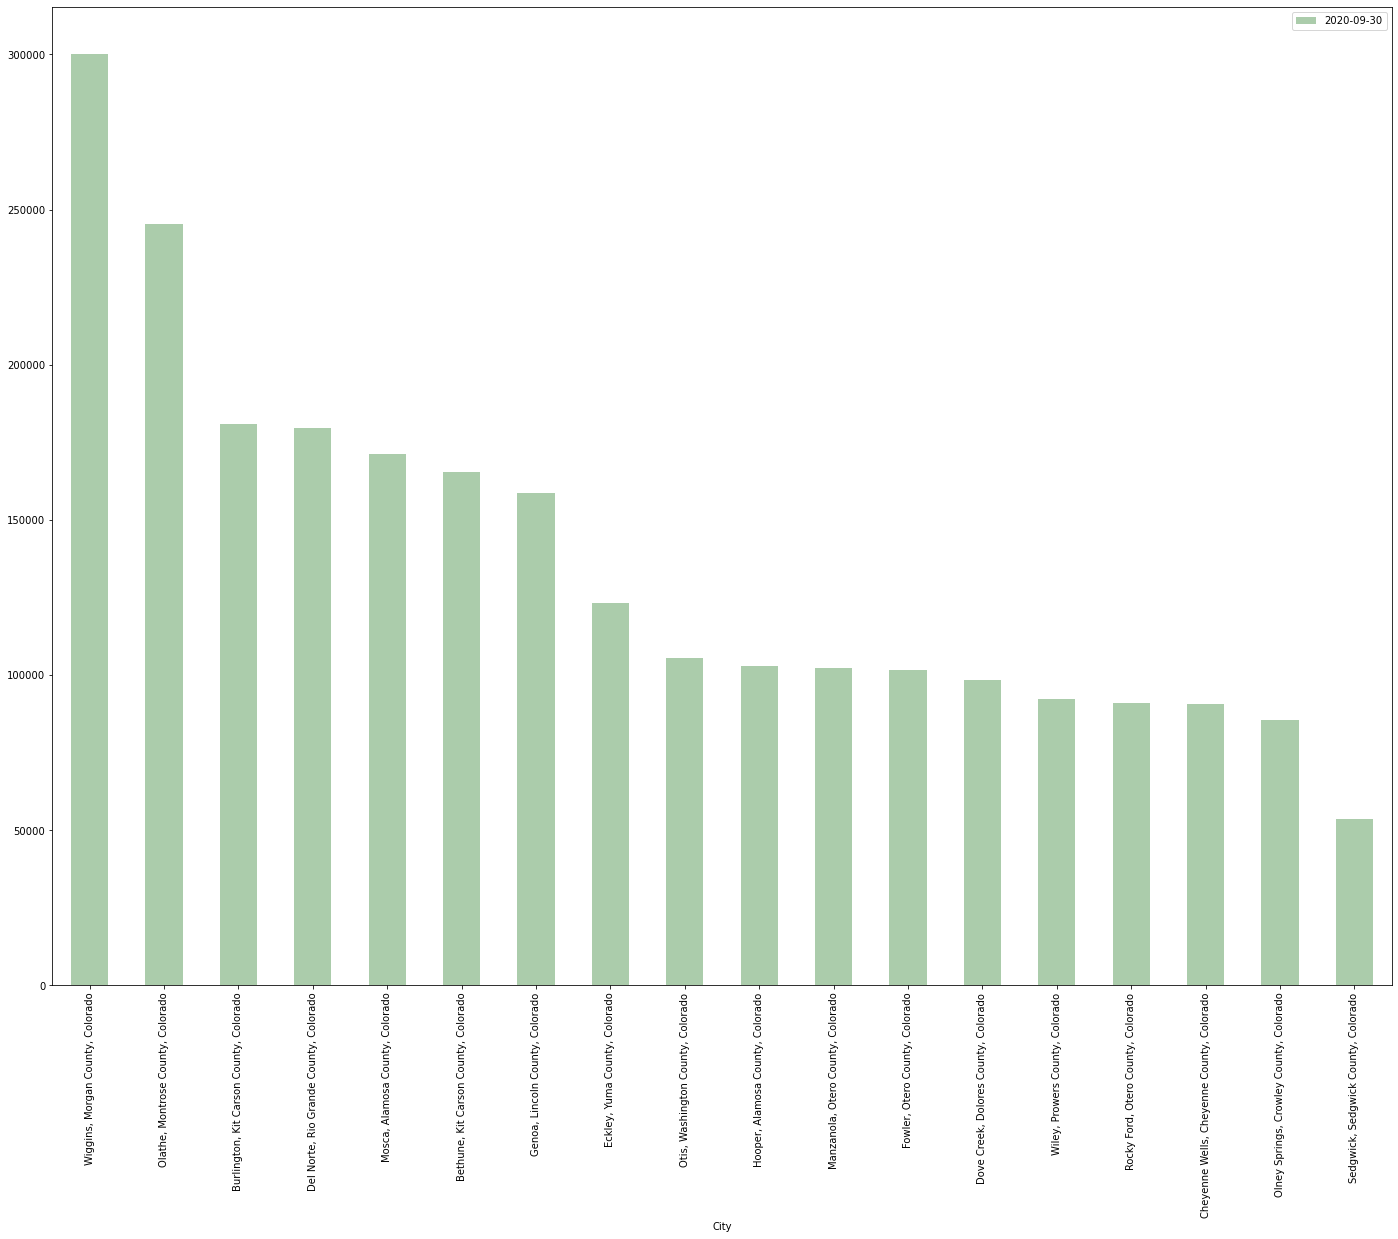

In [47]:
cluster0hv.plot(kind='bar', color='darkseagreen', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster0hv.png', bbox_inches='tight')

#### Cluster 1 
This cluster groups cities with one primary outdoor venue followed by near equal proportion of 2nd/3rd/4th outdoor venues

In [48]:
cluster1 = co_merged2.loc[co_merged2['Cluster Labels'] == 1]
cluster1

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
34,"Ignacio, La Plata County, Colorado",37.116250,-107.633956,291081.0,1.0,Campground,Park,Mountain,River
49,"Meeker, Rio Blanco County, Colorado",40.037473,-107.913130,244279.0,1.0,Campground,Farm,Mountain,Park
55,"Dolores, Montezuma County, Colorado",37.473882,-108.504536,301539.0,1.0,Campground,Park,Lake,Trail
58,"Ridgway, Ouray County, Colorado",38.152769,-107.761726,512188.0,1.0,Campground,Park,State / Provincial Park,Stables
63,"Hesperus, La Plata County, Colorado",37.286111,-108.039517,410825.0,1.0,Tree,Campground,Ski Area,Windmill
66,"Sanford, Costilla County, Colorado",37.408150,-105.679261,129777.0,1.0,Campground,Scenic Lookout,Windmill,Fishing Spot
68,"Antonito, Conejos County, Colorado",37.079179,-106.008633,128705.0,1.0,Campground,Castle,River,Fishing Spot
71,"Hayden, Routt County, Colorado",40.497673,-107.274682,332826.0,1.0,Nature Preserve,Trail,Campground,Harbor / Marina
72,"Limon, Lincoln County, Colorado",39.264854,-103.693124,162748.0,1.0,Campground,Forest,Windmill,Fishing Spot
73,"Kremmling, Grand County, Colorado",40.058739,-106.388630,322609.0,1.0,Campground,Farm,Stables,Rafting


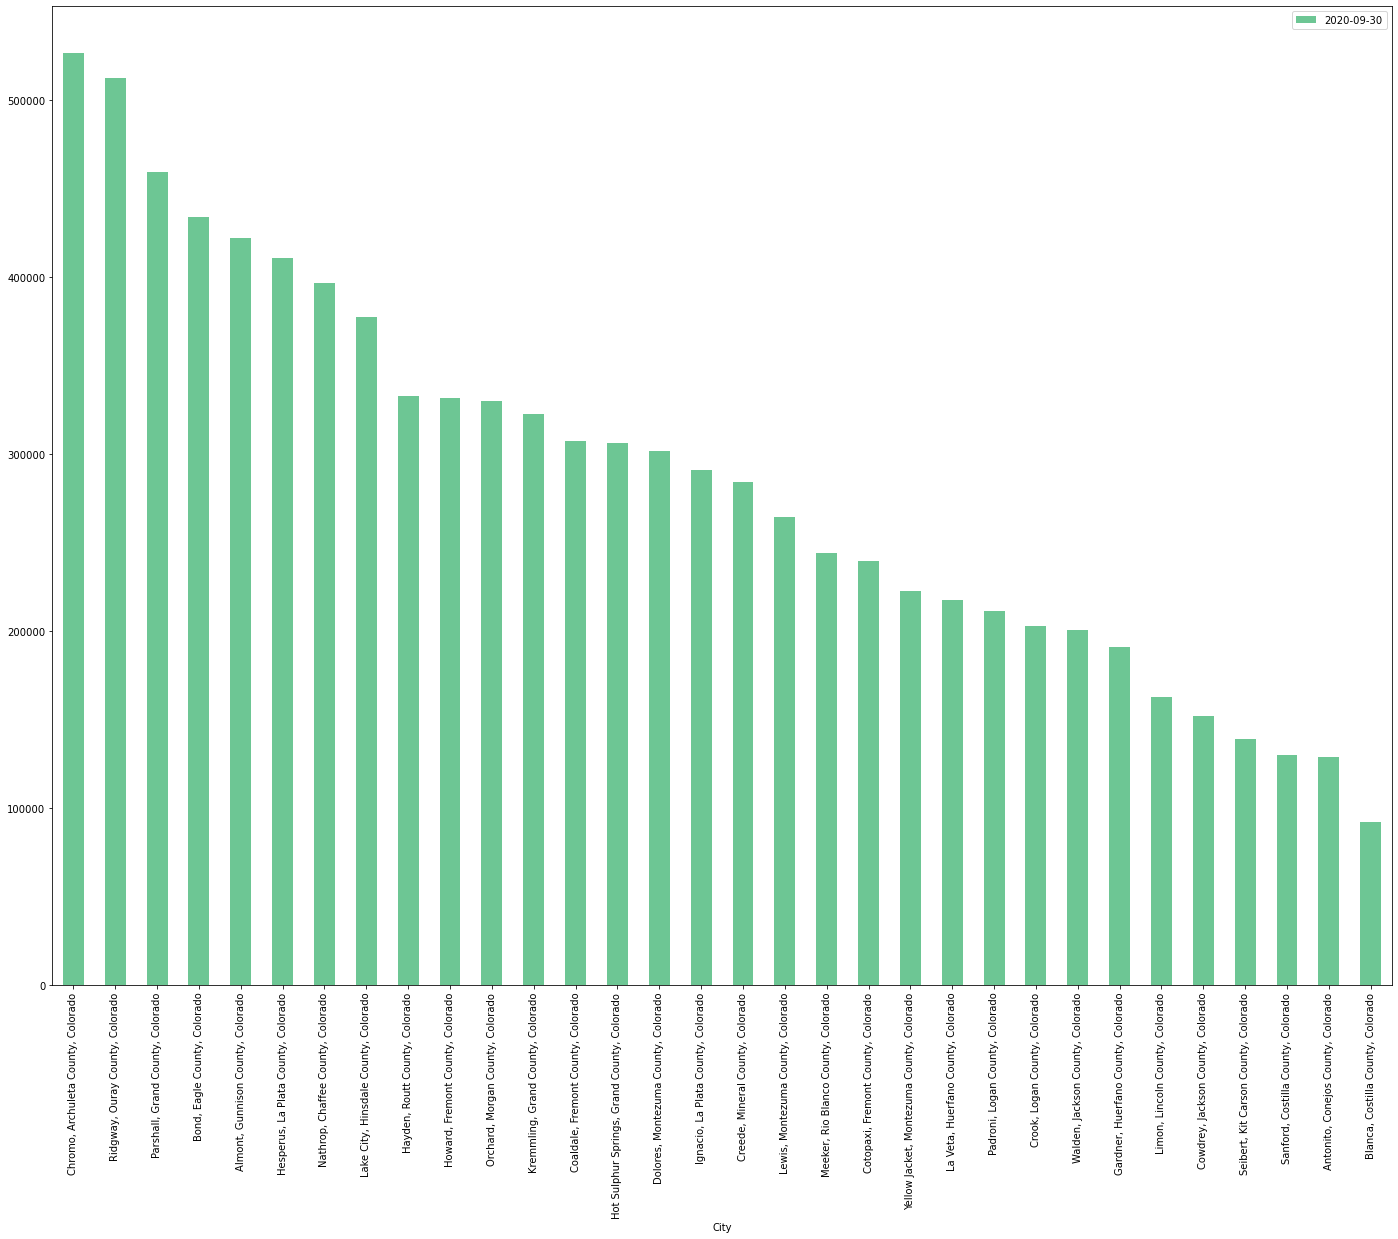

In [49]:
cluster1hv = cluster1[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster1hv.set_index('City', inplace=True)
cluster1hv.plot(kind='bar', color='mediumseagreen', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster1hv.png', bbox_inches='tight')

#### Cluster2 - Rural / Small Town -- Parks/Paintball
This cluster contains small cities in predominantly in lower elevations of state.  This cluster is outside of our scope of interest.

In [50]:
cluster2 = co_merged2.loc[co_merged2['Cluster Labels'] == 2]
cluster2.sort_values('2020-09-30', ascending=False).tail(20)


,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
65,"Paonia, Delta County, Colorado",38.868321,-107.592002,293935.0,2.0,Park,Paintball Field,Nature Preserve,National Park
135,"Atwood, Logan County, Colorado",40.545727,-103.279812,245698.0,2.0,Park,Paintball Field,Nature Preserve,National Park
132,"Fleming, Logan County, Colorado",40.679991,-102.839363,173842.0,2.0,Park,Paintball Field,Nature Preserve,National Park
45,"Yuma, Yuma County, Colorado",40.122208,-102.725210,173543.0,2.0,Park,Paintball Field,Nature Preserve,National Park
106,"Nucla, Montrose County, Colorado",38.269435,-108.547869,128982.0,2.0,Park,Campground,Fishing Spot,Nature Preserve
20,"La Junta, Otero County, Colorado",37.985009,-103.543832,101644.0,2.0,Park,Campground,Fishing Spot,Nature Preserve
205,"Arriba, Lincoln County, Colorado",39.286100,-103.275496,99431.0,2.0,Park,Paintball Field,Nature Preserve,National Park
182,"Naturita, Montrose County, Colorado",38.219091,-108.572693,78952.0,2.0,Park,Campground,Fishing Spot,Nature Preserve
102,"Swink, Otero County, Colorado",38.014054,-103.629588,70439.0,2.0,Park,Campground,Fishing Spot,Nature Preserve
107,"Crowley, Crowley County, Colorado",38.193061,-103.856065,48830.0,2.0,Park,Paintball Field,Nature Preserve,National Park


In [53]:
# create map of CO using latitude and longitude values
map_cluster2 = folium.Map(location=[39.250823, -106.29524], zoom_start=7)



# add markers to map
# add the city lat/long centerpoints to map as blue circle markers
for lat, lng, label in zip(cluster2.Lat, cluster2.Lon, cluster2.City):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='seagreen',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_cluster2)
    
map_cluster2

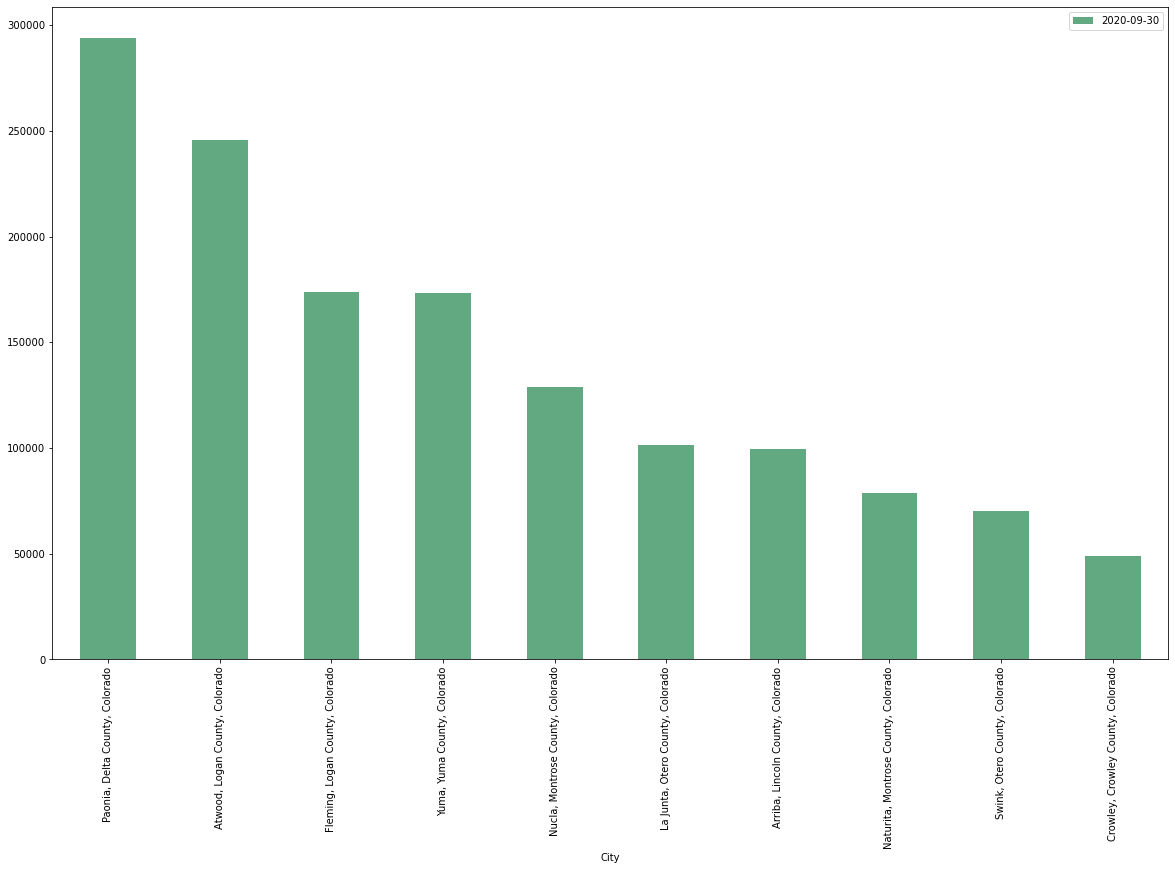

In [55]:
cluster2hv = cluster2[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster2hv.set_index('City', inplace=True)
cluster2hv.sort_values(by=['2020-09-30'])
cluster2hv.plot(kind='bar', color='seagreen', figsize=(20,12),alpha=0.75)
plt.savefig('Images/cluster2hv.png', bbox_inches='tight')

#### Cluster 3 River Towns

In [56]:
cluster3 = co_merged2.loc[co_merged2['Cluster Labels'] == 3]
cluster3

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
75,"Romeo, Conejos County, Colorado",37.172233,-105.985300,74325.0,3.0,River,Windmill,Fishing Spot,Nature Preserve
78,"De Beque, Mesa County, Colorado",39.334775,-108.215286,238358.0,3.0,River,Mountain,Windmill,Fishing Spot
114,"San Luis, Costilla County, Colorado",37.201236,-105.423769,95019.0,3.0,River,Sculpture Garden,Windmill,Fishing Spot
124,"Stratton, Kit Carson County, Colorado",39.303328,-102.604645,138477.0,3.0,River,Windmill,Fishing Spot,Nature Preserve
144,"Aguilar, Las Animas County, Colorado",37.402793,-104.653319,135975.0,3.0,Trail,River,Windmill,Farm
162,"Iliff, Logan County, Colorado",40.759156,-103.066589,215608.0,3.0,River,Farm,Fishing Spot,Nature Preserve
191,"Vona, Kit Carson County, Colorado",39.303604,-102.742983,131585.0,3.0,River,Windmill,Fishing Spot,Nature Preserve


In [57]:
# create map of CO using latitude and longitude values
map_cluster3 = folium.Map(location=[38.833958, -104.825349], zoom_start=7)



# add markers to map
# add the city lat/long centerpoints to map as circle markers
for lat, lng, label in zip(cluster3.Lat, cluster3.Lon, cluster3.City):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='teal',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_cluster3)
    
map_cluster3

In [ ]:
cluster3hv = cluster3[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster3hv.set_index('City', inplace=True)
cluster3hv.plot(kind='bar', color='teal', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster3hv.png', bbox_inches='tight')

### Cluster 4 -- Target Cluster
This cluster contains the cities most well known for outdoor recreation in Colorado.  From the high end ski resorts like Vail / Breckenridge to interesting mountain towns like Ouray, this cluster provides an interesting list to dive into further.   

In [60]:
cluster4 = co_merged2.loc[co_merged2['Cluster Labels'] == 4]
cluster4

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
2,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Tree,Athletics & Sports,Park,Trail
4,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Ski Trail,Ski Lodge,Park
6,"Fort Morgan, Morgan County, Colorado",40.250258,-103.799951,225409.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
9,"Glenwood Springs, Garfield County, Colorado",39.550745,-107.325500,526842.0,4.0,Trail,Park,Mountain,Hot Spring
16,"Pagosa Springs, Archuleta County, Colorado",37.269566,-107.010816,340053.0,4.0,Hot Spring,Park,National Park,Trail
...,...,...,...,...,...,...,...,...,...
223,"Parlin, Gunnison County, Colorado",38.503036,-106.729428,302446.0,4.0,Hot Spring,Windmill,Paintball Field,Nature Preserve
226,"Log Lane Village, Morgan County, Colorado",40.270536,-103.829673,107117.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
227,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0,4.0,Athletics & Sports,Trail,Park,Rafting
230,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0,4.0,Mountain,Hot Spring,Windmill,Paintball Field


In [72]:
pd.set_option('display.max_rows', None)
print(cluster4.City)

2                 Montrose, Montrose County, Colorado
4           Steamboat Springs, Routt County, Colorado
6                Fort Morgan, Morgan County, Colorado
9         Glenwood Springs, Garfield County, Colorado
16         Pagosa Springs, Archuleta County, Colorado
17              Breckenridge, Summit County, Colorado
18                     Aspen, Pitkin County, Colorado
19                       Vail, Eagle County, Colorado
21              Silverthorne, Summit County, Colorado
23                   Salida, Chaffee County, Colorado
27                    Edwards, Eagle County, Colorado
28                   Leadville, Lake County, Colorado
31              Buena Vista, Chaffee County, Colorado
33              New Castle, Garfield County, Colorado
35                       Avon, Eagle County, Colorado
36                     Granby, Grand County, Colorado
37                 Mancos, Montezuma County, Colorado
42                  Las Animas, Bent County, Colorado
43                  Keystone

The median housing values shows a very wide distribution, indicating a potential for growth/appreciation in some of the towns in the middle/lower tier of the distribution.

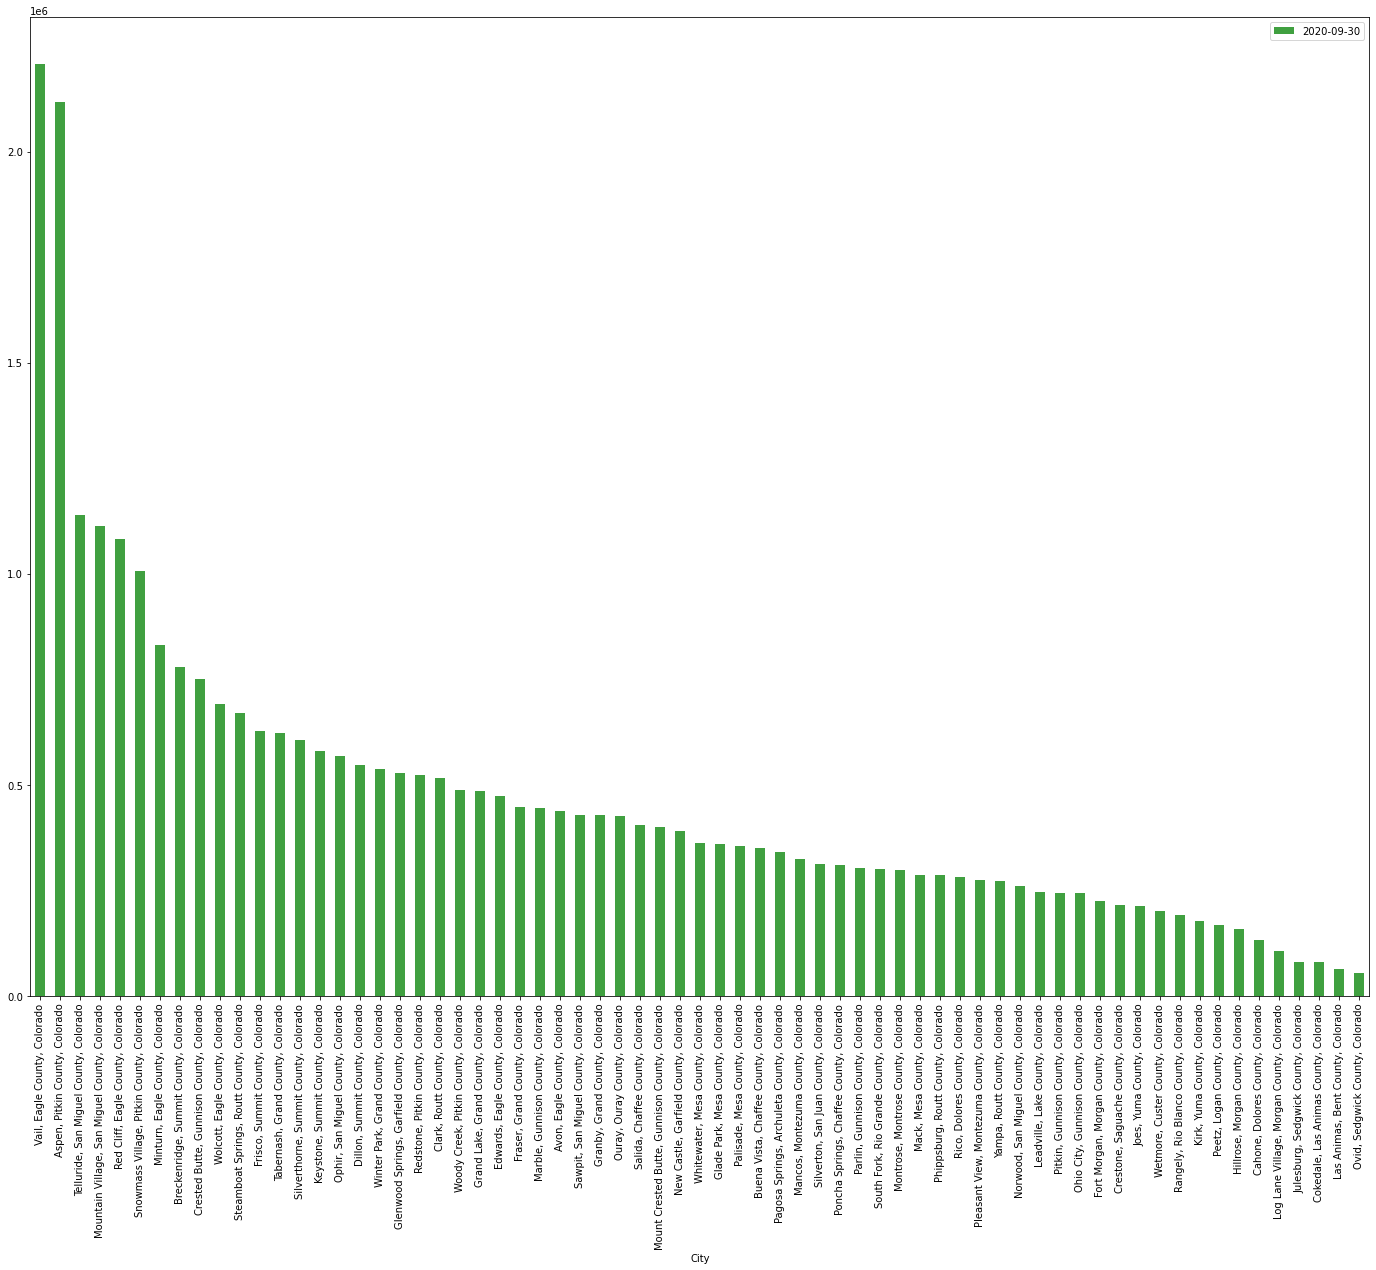

In [59]:
cluster4hv = cluster4[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster4hv.set_index('City', inplace=True)
cluster4hv.plot(kind='bar', color='green', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster4hv.png', bbox_inches='tight')

In [61]:
# create map of CO using latitude and longitude values
map_cluster4 = folium.Map(location=[38.833958, -104.825349], zoom_start=7)



# add markers to map
# add the city lat/long centerpoints to map as circle markers
for lat, lng, label in zip(cluster4.Lat, cluster4.Lon, cluster4.City):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='teal',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_cluster4)
    
map_cluster4

#### Cluster 5 CO Lakes

In [64]:
cluster5 = co_merged2.loc[co_merged2['Cluster Labels'] == 5]
cluster5

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
39,"Cedaredge, Delta County, Colorado",38.901649,-107.926454,283595.0,5.0,Lake,Park,Campground,Scenic Lookout
70,"Ordway, Crowley County, Colorado",38.218061,-103.756061,68901.0,5.0,Park,Lake,Paintball Field,Nature Preserve
93,"Orchard City, Delta County, Colorado",38.828316,-107.970900,243595.0,5.0,Lake,Park,Skydiving Drop Zone,Farm
112,"Weston, Las Animas County, Colorado",37.132804,-104.848875,222294.0,5.0,Lake,Windmill,Paintball Field,Nature Preserve
136,"Merino, Logan County, Colorado",40.482482,-103.351328,217778.0,5.0,Lake,Park,Paintball Field,Nature Preserve
142,"Sugar City, Crowley County, Colorado",38.231949,-103.663001,56659.0,5.0,Park,Lake,Paintball Field,Nature Preserve
181,"Hasty, Bent County, Colorado",38.112507,-102.957423,102337.0,5.0,Lake,Campground,Windmill,Fishing Spot
186,"Meredith, Pitkin County, Colorado",39.355541,-106.738647,444538.0,5.0,Lake,Campground,Windmill,Fishing Spot
194,"Mesa, Mesa County, Colorado",39.166110,-108.139506,326175.0,5.0,Lake,Campground,Windmill,Fishing Spot
207,"Molina, Mesa County, Colorado",39.189146,-108.060351,369501.0,5.0,Lake,Campground,Windmill,Fishing Spot


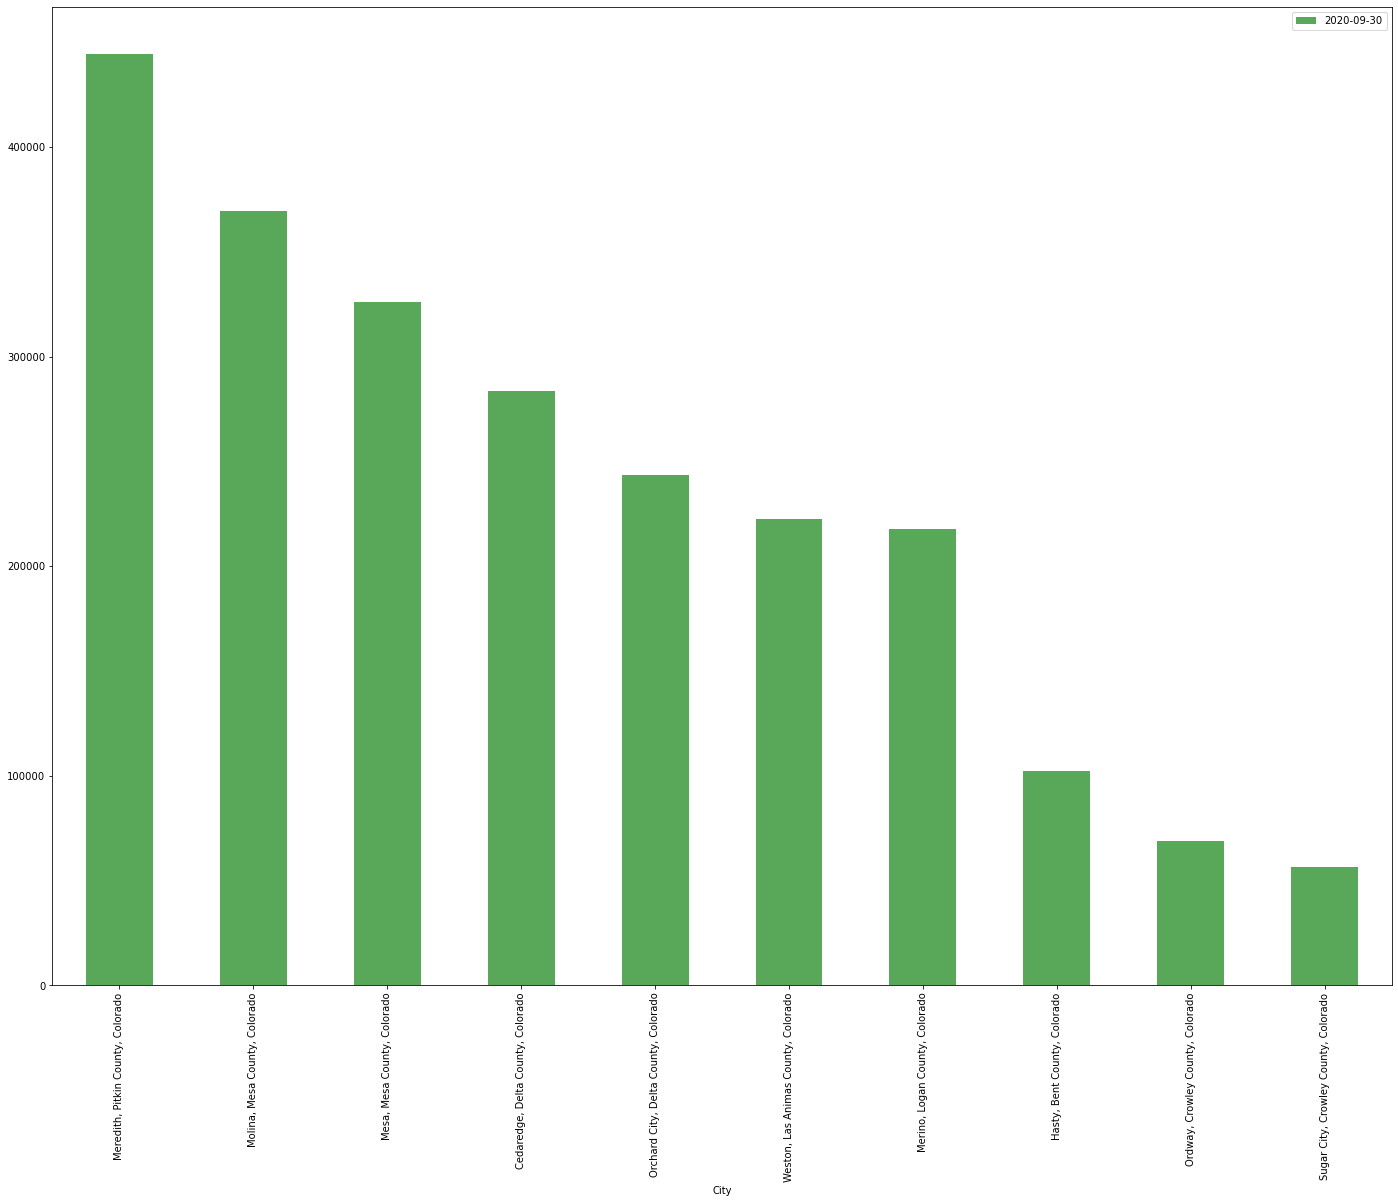

In [63]:
cluster5hv = cluster5[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster5hv.set_index('City', inplace=True)
cluster5hv.plot(kind='bar', color='forestgreen', figsize=(24,18),alpha=0.75)
plt.savefig('cluster5hv.png', bbox_inches='tight')

#### Cluster 6 - Lake / Park Density

This cluster is also worth investing additional research into, as the top venues are typically lakes/parks/waterfalls and at a much lower price point.

In [65]:
cluster6 = co_merged2.loc[co_merged2['Cluster Labels'] == 6]
cluster6

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
15,"Gypsum, Eagle County, Colorado",39.646929,-106.951711,364348.0,6.0,Tree,Windmill,Farm,Nature Preserve
51,"Hotchkiss, Delta County, Colorado",38.799707,-107.719503,318752.0,6.0,Tree,Windmill,Farm,Nature Preserve
149,"Saguache, Saguache County, Colorado",38.087539,-106.142084,151670.0,6.0,Tree,Windmill,Farm,Nature Preserve


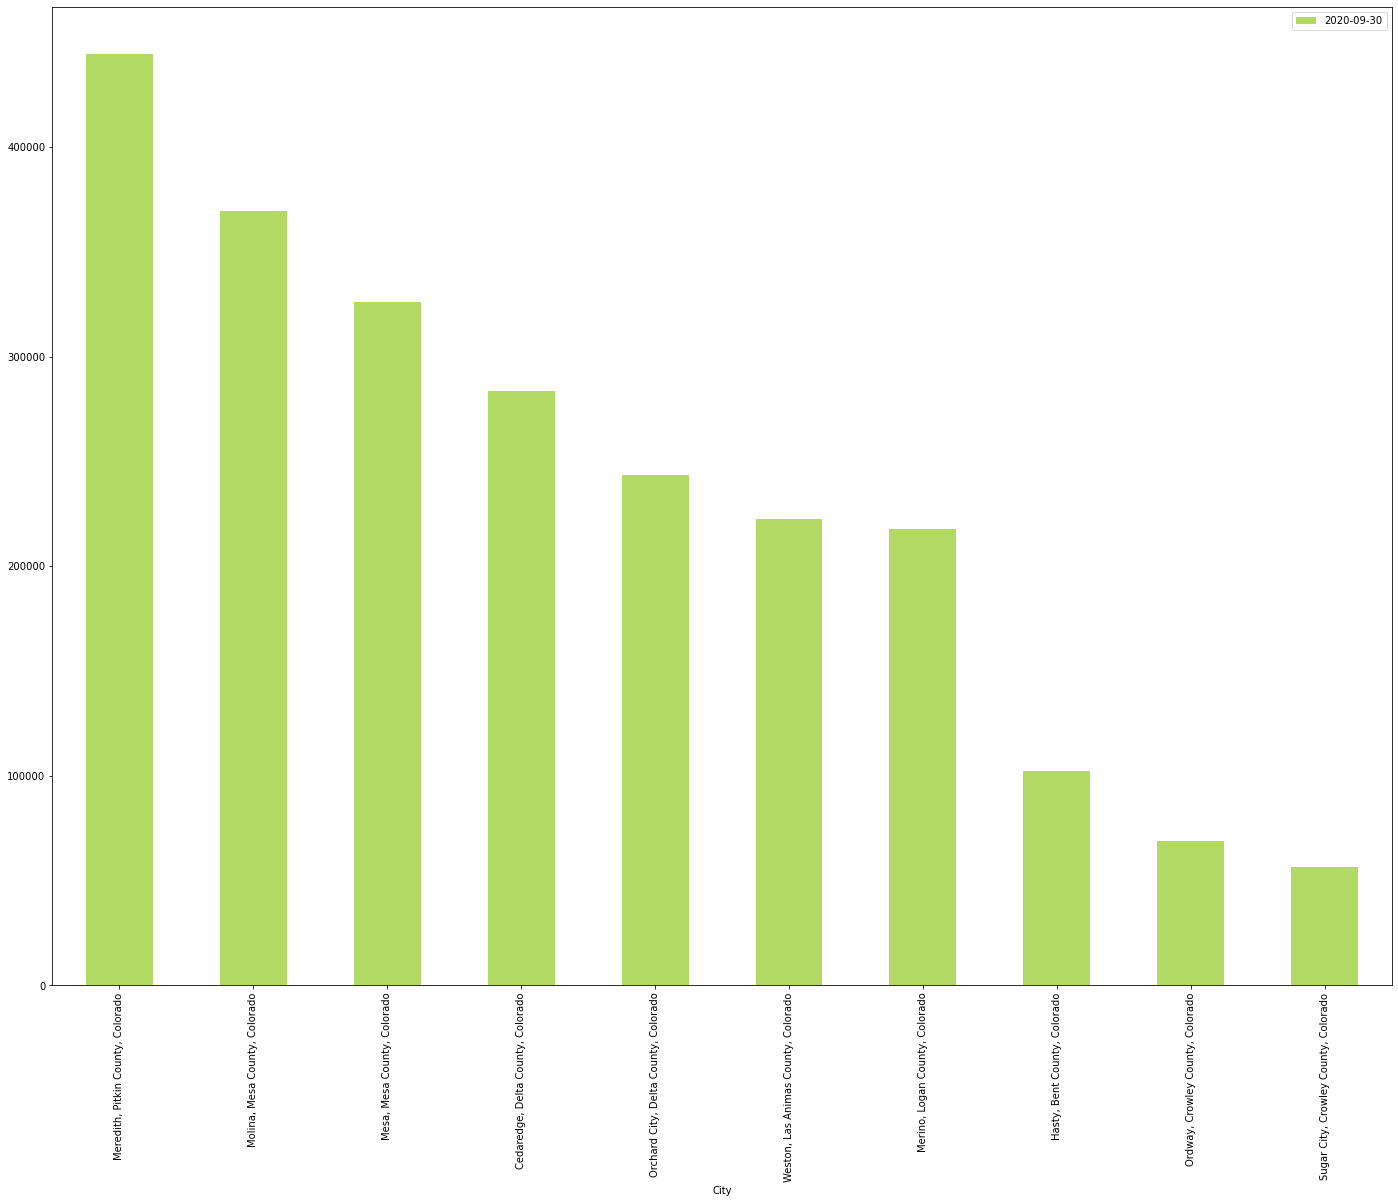

In [66]:
cluster6hv = cluster5[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster6hv.set_index('City', inplace=True)
cluster6hv.plot(kind='bar', color='yellowgreen', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster6hv.png', bbox_inches='tight')

#### Cluster 7 -- Another cluster to investigate further // high prevalence of parks/trails/rafting

In [67]:
cluster7 = co_merged2.loc[co_merged2['Cluster Labels'] == 7]
cluster7

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,7.0,Trail,Park,Athletics & Sports,Climbing Gym
1,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,7.0,Park,Rafting,Trail,Tree
3,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,7.0,Park,Scenic Lookout,Tree,Trail
5,"Sterling, Logan County, Colorado",40.625541,-103.207709,180273.0,7.0,Park,Ski Area,Nature Preserve,National Park
7,"Cortez, Montezuma County, Colorado",37.349453,-108.584074,216005.0,7.0,Park,National Park,Campground,Fishing Spot
8,"Alamosa, Alamosa County, Colorado",37.469877,-105.869600,188761.0,7.0,Park,Trail,Campground,Fishing Spot
10,"Fruita, Mesa County, Colorado",39.158870,-108.728988,315148.0,7.0,Park,Trail,Scenic Lookout,State / Provincial Park
11,"Delta, Delta County, Colorado",38.743612,-108.072917,227652.0,7.0,Park,Tree,Farm,Nature Preserve
12,"Clifton, Mesa County, Colorado",39.080073,-108.459277,211351.0,7.0,Park,Trail,Athletics & Sports,Tree
13,"Rifle, Garfield County, Colorado",39.534702,-107.783120,316683.0,7.0,Park,Rafting,Fishing Spot,Nature Preserve


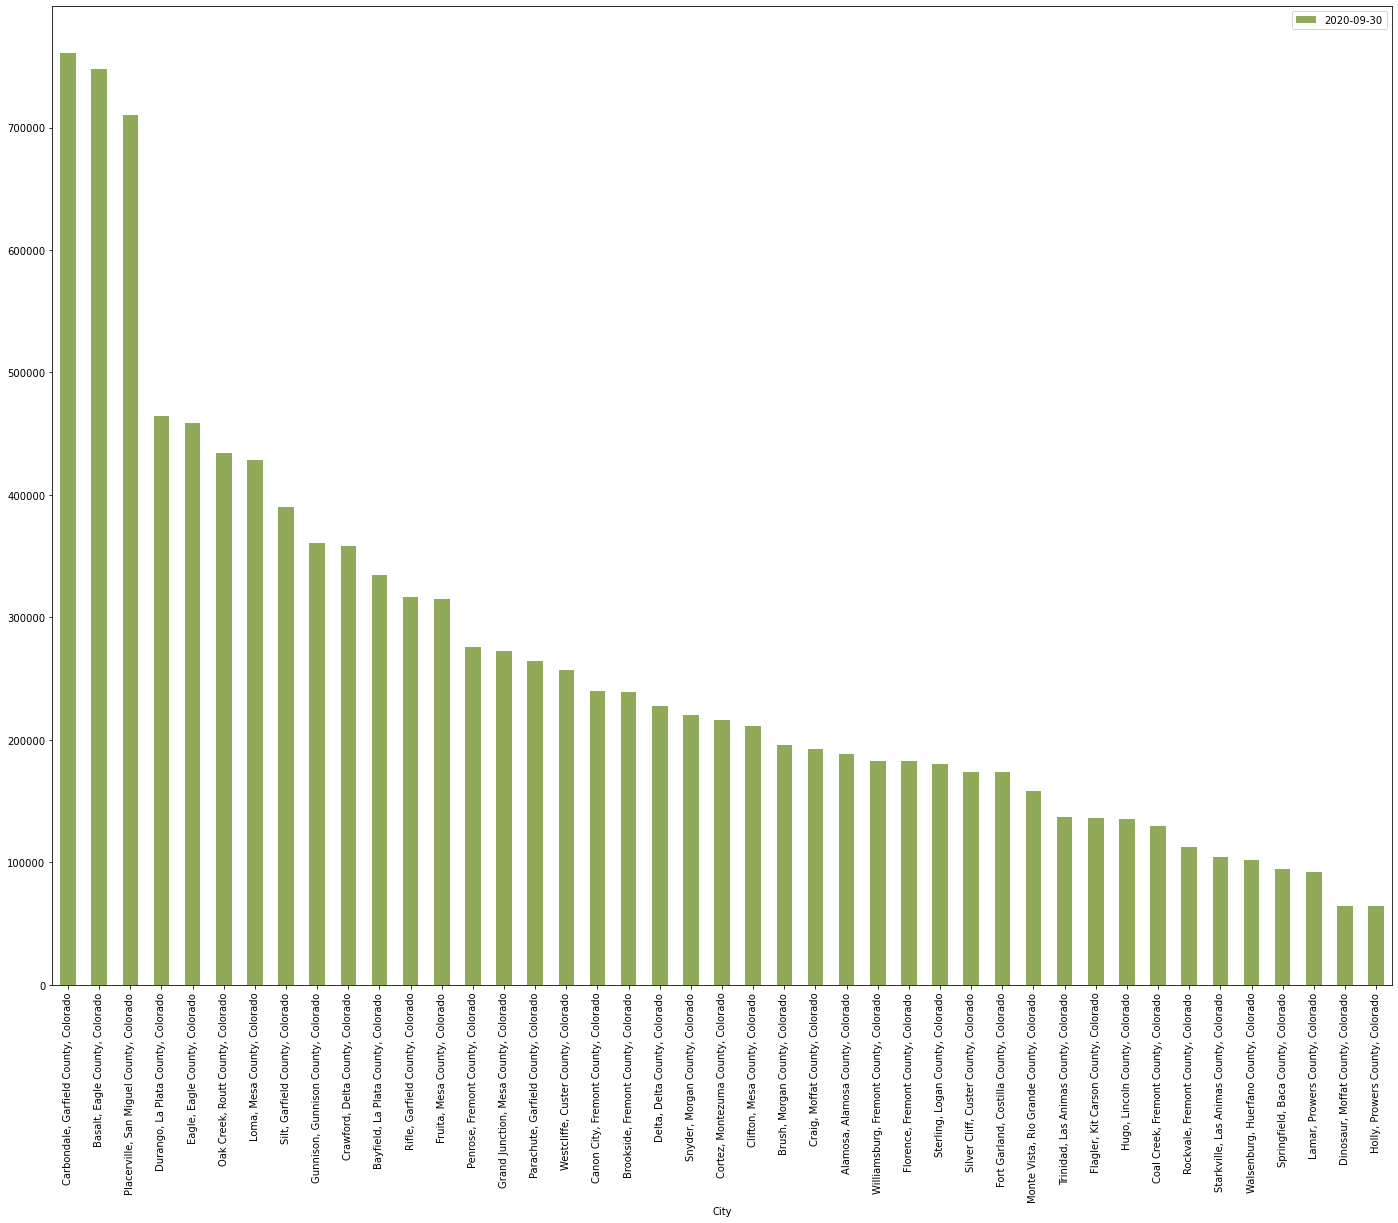

In [69]:
cluster7hv = cluster7[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster7hv.set_index('City', inplace=True)
cluster7hv.plot(kind='bar', color='olivedrab', figsize=(24,18),alpha=0.75)
plt.savefig('Images/cluster7hv.png', bbox_inches='tight')